# Graphsage direct paper classification with extra node attributes


In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
    %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 8.8 MB/s 
     |████████████████████████████████| 482 kB 43.8 MB/s 
     |████████████████████████████████| 462 kB 50.7 MB/s 
     |████████████████████████████████| 41 kB 348 kB/s 


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

import stellargraph as sg
from stellargraph import StellarGraph, StellarDiGraph
from stellargraph import globalvar
from stellargraph import random as sg_random
from stellargraph.mapper import GraphSAGENodeGenerator, DirectedGraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, MeanAggregator, DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow import random as tf_random
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.utils.multiclass import unique_labels
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

import torch
torch.cuda.is_available()


sg_random.set_seed(42)
tf_random.set_seed(42)
%matplotlib inline

Mounted at /content/drive


## Paths

In [26]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
PATH_DATES = parent_path+'WebMining/data/raw/hep-th-slacdates_unzipped.txt'
PATH_CITATION = parent_path+'WebMining/data/raw/hep-th-citations_unzipped_filtered.txt'
PATH_LABEL = parent_path+'WebMining/data/processed/papers_label.csv'
PATH_ATTRIBUTES = parent_path+'WebMining/data/processed/all_features_with_further_preprocessing.csv'

PATH_MODEL_GS_D_F = parent_path+'WebMining/models/graphsage_directed_extra_feat.hdf5'

#Specific paths
#PATH_DATES = 'hep-th-slacdates_unzipped.txt'
#PATH_CITATION = 'hep-th-citations_unzipped_filtered.txt'
#PATH_LABEL = 'papers_label.csv'
#PATH_ATTRIBUTES = 'all_features_with_further_preprocessing.csv'

#PATH_MODEL_GS_D_F = 'graphsage_directed_extra_feat.hdf5'


## Loading the dataset

In [4]:
def read_dates(path):
    df = pd.read_csv(path, sep=' ', header=None, names=['id_paper', 'slac_date'])
    df['slac_date'] = pd.to_datetime(df['slac_date'])
    display(df.head(5))
    return (df)

In [5]:
def read_citation(path, df):
    df = pd.read_csv(path, sep=' ', header=None, names=['source', 'target'])
    display(df.head(5))
    return(df)

In [6]:
def get_labels(path, df2, label, date):
    df1 = pd.read_csv(path, index_col=0)
    df1.index.name='id_paper'
    df2 = df2.set_index("id_paper")
    df1 = pd.merge(df1, df2, left_index=True, right_index=True)
    label_full = df1[label]
    label_train = df1[df1.slac_date < date][label]
    label_test = df1[df1.slac_date >= date][label]
    print('Full nodes: %s   Train nodes: %s   Test nodes: %s'%(len(label_full), len(label_train), len(label_test)))
    return (label_full, label_train, label_test)


In [7]:
def get_features(path, df2, date):
    # Papers ids 
    df1 = pd.read_csv(path, index_col=0)
    df1.index.name='id_paper'

    # Date df
    df2 = df2.set_index("id_paper")

    # Combine datasets
    df1 = pd.merge(df1, df2, left_index=True, right_index=True)

    # Date features
    df1['slac_date'] = pd.to_datetime(df1['slac_date'])
    df1['year']= df1[date].dt.year
    df1['month']= df1[date].dt.month
    df1['week']= df1[date].dt.isocalendar().week

    df1['month_sin'] = np.sin((df1.month-1)*(2.*np.pi/12))
    df1['month_cos'] = np.cos((df1.month-1)*(2.*np.pi/12))

    df1['week_sin'] = np.sin((df1[date].dt.isocalendar().week-1)*(2.*np.pi/53))
    df1['week_cos'] = np.cos((df1[date].dt.isocalendar().week-1)*(2.*np.pi/53))

    ls = ['year', 'month_sin', 'month_cos', 'week_sin', 'week_cos']
    df_date = df1[ls]
    display(df_date.head(5))
    return(df_date)


In [8]:
df_dates = read_dates(PATH_DATES)

,id_paper,slac_date
0,1001,2000-01-04
1,1002,2000-01-04
2,1003,2000-01-04
3,1004,2000-01-04
4,1005,2000-01-04


In [9]:
df_citation = read_citation(PATH_CITATION, df_dates)

,source,target
0,1001,9304045
1,1001,9308122
2,1001,9309097
3,1001,9311042
4,1001,9401139


In [10]:
full_nodes, train_nodes, test_nodes = get_labels(PATH_LABEL, df_dates, 'label', '2002-01-01')

Full nodes: 27750   Train nodes: 23567   Test nodes: 4183


In [11]:
df_attributes = get_features(PATH_LABEL, df_dates, 'slac_date')

,year,month_sin,month_cos,week_sin,week_cos
id_paper,,,,,
1001,2000,0.0,1.0,0.0,1.0
1002,2000,0.0,1.0,0.0,1.0
1003,2000,0.0,1.0,0.0,1.0
1004,2000,0.0,1.0,0.0,1.0
1005,2000,0.0,1.0,0.0,1.0


In [12]:
extra_features = [
    # 'Unnamed: 0', 
    # 'indegrees_of_cited_papers_sum',
    # 'indegrees_of_cited_papers_avg', 
    'recency_of_cited_papers_avg',
    'max_time_difference_bw_cited_papers', 
    # 'outdegree',
    # 'outdegrees_of_cited_papers_sum', 
    # 'outdegrees_of_cited_papers_avg',
    # 'submitter', 
    # 'submission_date', 
    # 'title', 
    # 'authors', 
    # 'comments',
    # 'report_no', 
    # 'journal_ref', 
    # 'abstract', 
    # 'submitter_email',
    # 'submitter_name', 
    # 'submitter_details', 
    'is_revised', 
    'times_revised',
    # 'first_submission_datetime', 
    # 'first_submission_date', 
    'num_of_pages',
    # 'format', 
    'journal_counts', 
    # 'first_365_days', 
    # 'label', 
    # 'label_name',
    'submitter_active', 
    # 'submitter_counts', 
    'journal_popularity',
    'format_latex', 
    'format_revtex', 
    'format_harvmac', 
    'format_plaintex',
    # 'date_added_graph', 
    # 'datedelta', 
    'citations_till_date',
]

df_extra_features = pd.read_csv(
    PATH_ATTRIBUTES, 
    index_col=1
)[extra_features].fillna(0)

df_attributes = pd.merge(
    df_attributes, 
    df_extra_features, 
    how='inner',
    left_index=True, 
    right_index=True
).rename_axis('id_paper')

df_attributes.head()

,year,month_sin,month_cos,week_sin,week_cos,recency_of_cited_papers_avg,max_time_difference_bw_cited_papers,is_revised,times_revised,num_of_pages,journal_counts,submitter_active,journal_popularity,format_latex,format_revtex,format_harvmac,format_plaintex,citations_till_date
id_paper,,,,,,,,,,,,,,,,,,
1001,2000,0.0,1.0,0.0,1.0,1182.903614,2394.0,1,1,82.0,0.0,1,0,1,0,0,0,33
1002,2000,0.0,1.0,0.0,1.0,627.500000,2899.0,0,0,11.0,105.0,1,1,1,0,0,0,176
1003,2000,0.0,1.0,0.0,1.0,11.000000,0.0,0,0,4.0,0.0,0,0,0,1,0,0,0
1004,2000,0.0,1.0,0.0,1.0,442.000000,0.0,0,0,7.0,192.0,0,1,1,1,0,0,0
1005,2000,0.0,1.0,0.0,1.0,602.047619,2201.0,0,0,18.0,0.0,0,0,1,0,0,0,0


## Graph construction

In [13]:
graph_citation_full = StellarDiGraph({"paper": df_attributes}, {"cites": df_citation})
print(graph_citation_full.info())


StellarDiGraph: Directed multigraph
 Nodes: 27750, Edges: 351763

 Node types:
  paper: [27750]
    Features: float32 vector, length 18
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [351763]
        Weights: all 1 (default)
        Features: none


In [14]:
graph_citation_train = graph_citation_full.subgraph(train_nodes.index)
print(graph_citation_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 23567, Edges: 271167

 Node types:
  paper: [23567]
    Features: float32 vector, length 18
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [271167]
        Weights: all 1 (default)
        Features: none


### Splitting the data

In [15]:
train_labels, test_labels = model_selection.train_test_split(
    train_nodes,
    train_size=0.7, #0.05
    test_size=None,
    stratify=train_nodes,
    random_state=42,
)

val_labels, test_labels = model_selection.train_test_split(
    test_labels, 
    train_size=0.67, #0.2
    test_size=None, 
    stratify=test_labels, 
    random_state=42,
)

Stratified sampling gives the following counts:

In [16]:
Counter(train_labels)

Counter({0: 5044, 1: 9509, 2: 1103, 3: 840})

The training set has class imbalance is compensated, with class weights inversely proportional to class support.

In [17]:
#get class_weights
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_labels),
    y = train_labels                                                    
)
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 0.8176050753370341,
 1: 0.43369439478388894,
 2: 3.7388939256572984,
 3: 4.90952380952381}

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [18]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model we need a generator. The generators are specialized to the model and the learning task so we choose the `DirectedGraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need specify the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-layer model with 10 in-nodes sampled in the first layer, and 4 in-nodes in the second layer.

In [19]:
batch_size = 50
in_samples = [1, 1]
out_samples = [10, 4]

generator = DirectedGraphSAGENodeGenerator(graph_citation_train, batch_size, in_samples, out_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [20]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)
val_gen = generator.flow(val_labels.index, val_targets, shuffle=True)
test_gen = generator.flow(test_labels.index, test_targets)

Now we can specify our machine learning model, and use 2 layers of 32 neurons each of them. And a dropout of 0.1 to help the model to generalize.

In [21]:
graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.1 #, activations=["relu"] or  activation=keras.layers.LeakyReLU(alpha=0.01)
)

Now we create a model to predict the 4 categories using Keras softmax layers.

In [22]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)


In [23]:
prediction.shape

TensorShape([None, 4])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [24]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-04),
    loss = losses.categorical_crossentropy, #weighted_categorical_crossentropy(weights)
    metrics = [
        metrics.AUC(),
        metrics.CategoricalAccuracy(),
    ] #= ['accuracy'],
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 18)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10, 18)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1, 18)]      0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 4, 18)]      0           []                               
                                                                                              

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set.

In [27]:
# create callback
callback = ModelCheckpoint(
    filepath=PATH_MODEL_GS_D_F,
    monitor='val_categorical_accuracy',
    verbose=1, 
    save_best_only=True,
    mode='max'
)

#fit the model
history = model.fit(
    train_gen, 
    epochs=100, 
    validation_data=val_gen, 
    class_weight=class_weights,
    verbose=1, 
    shuffle=True,
    callbacks=[callback]
)


Epoch 1/100
330/330 [==============================] - ETA: 0s - loss: 1.3739 - auc: 0.4147 - categorical_accuracy: 0.2259
Epoch 1: val_categorical_accuracy improved from -inf to 0.22060, saving model to /content/drive/My Drive/WebMining/models/graphsage_directed_extra_feat.hdf5
330/330 [==============================] - 18s 48ms/step - loss: 1.3739 - auc: 0.4147 - categorical_accuracy: 0.2259 - val_loss: 1.3905 - val_auc: 0.4682 - val_categorical_accuracy: 0.2206
Epoch 2/100
330/330 [==============================] - ETA: 0s - loss: 1.3372 - auc: 0.5501 - categorical_accuracy: 0.2686
Epoch 2: val_categorical_accuracy improved from 0.22060 to 0.29533, saving model to /content/drive/My Drive/WebMining/models/graphsage_directed_extra_feat.hdf5
330/330 [==============================] - 19s 57ms/step - loss: 1.3372 - auc: 0.5501 - categorical_accuracy: 0.2686 - val_loss: 1.3525 - val_auc: 0.5579 - val_categorical_accuracy: 0.2953
Epoch 3/100
330/330 [==============================] - ETA:

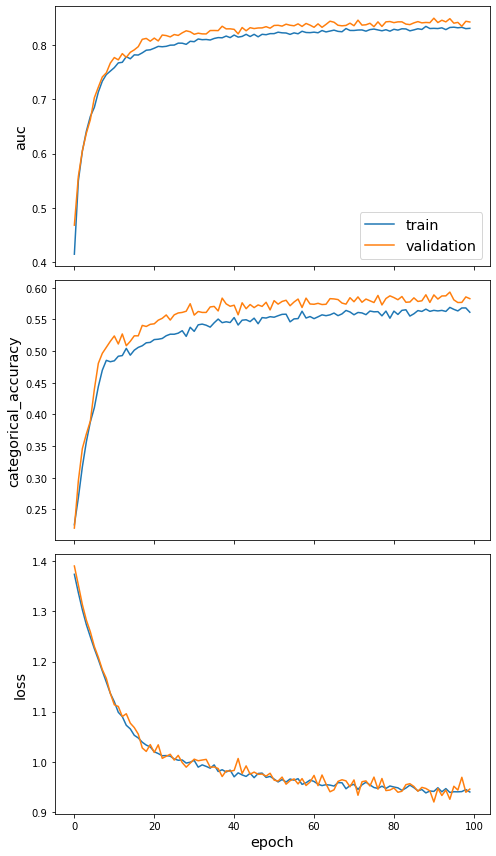

In [28]:
sg.utils.plot_history(history)

### Evaluate the Model

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Now we have trained the model we can evaluate on the test set.

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       714
           1       0.77      0.52      0.62      1345
           2       0.14      0.33      0.20       156
           3       0.26      0.76      0.39       119

    accuracy                           0.57      2334
   macro avg       0.47      0.58      0.48      2334
weighted avg       0.68      0.57      0.61      2334

47/47 [==============================] - 2s 35ms/step - loss: 0.9417 - auc: 0.8421 - categorical_accuracy: 0.5848

Test Set Metrics:
	loss: 0.9417
	auc: 0.8421
	categorical_accuracy: 0.5848


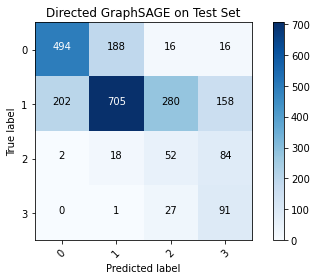

In [30]:
# Make prediction
predictions = model.predict(test_gen)
predictions = target_encoding.inverse_transform(predictions)
results = pd.Series(predictions, index=test_labels.index)

test_gen = generator.flow(test_labels.index, test_targets)

# Evaluation Metrics
cm = confusion_matrix(test_labels, results) #results intead of predictions
plot_confusion_matrix(cm, classes = unique_labels(train_labels), title = "Directed GraphSAGE on Test Set")
print(classification_report(test_labels, results))

# Performance
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

## Making predictions with the model in papers pubblished in 2002 and *2003*

In [31]:
#Load and evaluate the best model version
model = load_model(PATH_MODEL_GS_D_F, custom_objects={'MeanAggregator': MeanAggregator})

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1537
           1       0.96      0.43      0.59      2209
           2       0.09      0.41      0.14       233
           3       0.17      0.55      0.26       204

    accuracy                           0.60      4183
   macro avg       0.54      0.57      0.48      4183
weighted avg       0.86      0.60      0.67      4183

84/84 [==============================] - 3s 34ms/step - loss: 0.9390 - auc: 0.8395 - categorical_accuracy: 0.6058

Prediction Set Metrics:
	loss: 0.9390
	auc: 0.8395
	categorical_accuracy: 0.6058


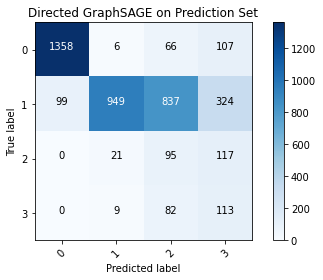

In [32]:
# Introduce prediction nodes
generator = DirectedGraphSAGENodeGenerator(graph_citation_full, batch_size, in_samples, out_samples)
prediction_targets = target_encoding.transform(test_nodes)
prediction_gen = generator.flow(test_nodes.index, prediction_targets)

# Make prediction
predictions = model.predict(prediction_gen)
predictions = target_encoding.inverse_transform(predictions)

# Create prediction dataset
results = pd.Series(predictions, index=test_nodes.index)
df_results = pd.DataFrame({"Predicted": results, "True": test_nodes})

# Evaluation Metrics
cm = confusion_matrix(test_nodes, results) #results intead of predictions
plot_confusion_matrix(cm, classes = unique_labels(train_labels), title = "Directed GraphSAGE on Prediction Set")
print(classification_report(test_nodes, results))

# Performance
prediction_metrics = model.evaluate(prediction_gen)
print("\nPrediction Set Metrics:")
for name, val in zip(model.metrics_names, prediction_metrics):
    print("\t{}: {:0.4f}".format(name, val))